# Affordance Heatmaps

This notebook visualizes the pick and place affordance predictions of a pre-trained `multi-language-conditioned` agent from the quickstart guide.

### Setup

- Set the root folder environment variable with `export CLIPORT_ROOT=<cliport_root>`
- Complete the [quickstart guide](https://github.com/cliport/cliport#quickstart) in README.md
- Generate `val` and `test` splits for the task you want to evaluate on by running `python cliport/demos.py n=10 mode=test task=stack-block-pyramid-seq-seen-colors`

In [12]:
# set GPU
%env CUDA_VISIBLE_DEVICES=0

import os
import sys
import json

import numpy as np
from cliport import tasks
from cliport import agents
from cliport.utils import utils

import torch
import cv2
from cliport.dataset import RavensDataset
from cliport.environments.environment import Environment

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

env: CUDA_VISIBLE_DEVICES=0


### Settings

In [13]:
train_demos = 1000 # number training demonstrations used to train agent
n_eval = 1 # number of evaluation instances
mode = 'test' # val or test

agent_name = 'cliport'
model_task = 'multi-language-conditioned' # multi-task agent conditioned with language goals

model_folder = 'cliport_quickstart' # path to pre-trained checkpoint
ckpt_name = 'steps=400000-val_loss=0.00014655.ckpt' # name of checkpoint to load

draw_grasp_lines = True
affordance_heatmap_scale = 30

### Uncomment the task you want to evaluate on ###
# eval_task = 'align-rope'
# eval_task = 'assembling-kits-seq-seen-colors'
# eval_task = 'assembling-kits-seq-unseen-colors'
eval_task = 'packing-shapes'
# eval_task = 'packing-boxes-pairs-seen-colors'
# eval_task = 'packing-boxes-pairs-unseen-colors'
# eval_task = 'packing-seen-google-objects-seq'
# eval_task = 'packing-unseen-google-objects-seq'
# eval_task = 'packing-seen-google-objects-group'
# eval_task = 'packing-unseen-google-objects-group'
# eval_task = 'put-block-in-bowl-seen-colors'
# eval_task = 'put-block-in-bowl-unseen-colors'
# eval_task = 'stack-block-pyramid-seq-seen-colors'
# eval_task = 'stack-block-pyramid-seq-unseen-colors'
# eval_task = 'separating-piles-seen-colors'
# eval_task = 'separating-piles-unseen-colors'
# eval_task = 'towers-of-hanoi-seq-seen-colors'
# eval_task = 'towers-of-hanoi-seq-unseen-colors'

### Load Configs and Agent

In [14]:
root_dir = '/sfs/weka/scratch/ys5hd/cliport'
#os.environ['CLIPORT_ROOT']
assets_root = os.path.join(root_dir, 'cliport/environments/assets/')
config_file = 'eval.yaml' 

vcfg = utils.load_hydra_config(os.path.join(root_dir, f'cliport/cfg/{config_file}'))
vcfg['data_dir'] = os.path.join(root_dir, 'cliport/data')
vcfg['mode'] = mode

vcfg['model_task'] = model_task
vcfg['eval_task'] = eval_task
vcfg['agent'] = agent_name

# Model and training config paths
model_path = os.path.join(root_dir, model_folder)
vcfg['train_config'] = f"{model_path}/{vcfg['model_task']}-{vcfg['agent']}-n{train_demos}-train/.hydra/config.yaml"
vcfg['model_path'] = f"{model_path}/{vcfg['model_task']}-{vcfg['agent']}-n{train_demos}-train/checkpoints/"

tcfg = utils.load_hydra_config(vcfg['train_config'])

# Load dataset
ds = RavensDataset(os.path.join(vcfg['data_dir'], f'{vcfg["eval_task"]}-{vcfg["mode"]}'), 
                   tcfg, 
                   n_demos=n_eval,
                   augment=False)

eval_run = 0
name = '{}-{}-{}-{}'.format(vcfg['eval_task'], vcfg['agent'], n_eval, eval_run)
print(f'\nEval ID: {name}\n')

# Initialize agent
utils.set_seed(eval_run, torch=True)
agent = agents.names[vcfg['agent']](name, tcfg, None, ds)

# Load checkpoint
ckpt_path = os.path.join(vcfg['model_path'], ckpt_name)
print(f'\nLoading checkpoint: {ckpt_path}')
agent.load(ckpt_path)


Eval ID: packing-shapes-cliport-1-0

Attn FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: add
Transport FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: conv
Agent: packing-shapes-cliport-1-0, Logging: False

Loading checkpoint: /sfs/weka/scratch/ys5hd/cliport/cliport_quickstart/multi-language-conditioned-cliport-n1000-train/checkpoints/steps=400000-val_loss=0.00014655.ckpt


### Spawn Environment

In [15]:
# Initialize environment and task.
env = Environment(
    assets_root,
    disp=False,
    shared_memory=False,
    hz=480,
    record_cfg=False
)

In [16]:
episode, seed = ds.load(1)
goal = episode[-1]

total_reward = 0
np.random.seed(seed)

task_name = vcfg['eval_task']
task = tasks.names[task_name]()
task.mode = mode

env.seed(seed)
env.set_task(task)

obs = env.reset()
info = env.info

text argument:/sfs/weka/scratch/ys5hd/cliport/cliport/environments/assets/
int args: [

In [17]:
reward = 0

step = 0
done = False

batch = ds.process_sample((obs, None, reward, info), augment=False)

In [18]:
batch.keys()

dict_keys(['img', 'p0', 'p0_theta', 'p1', 'p1_theta', 'perturb_params', 'lang_goal'])

In [19]:
batch['lang_goal']

'pack the hexagon in the brown box'

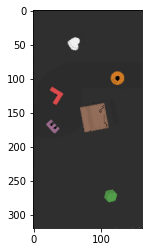

In [21]:
# (batch['img'][:, :, 4] == batch['img'][:, :, 3]).all()

plt.imshow(batch['img'][:, :, :3].astype(int))
# plt.savefig('green_block_on_brown_block.png')

In [22]:
# from PIL import Image
# im = Image.fromarray(batch['img'][:, :, :3].astype(np.uint8))
# im.save("green_block_on_brown.jpeg")

### Evaluate Agent


Evaluation Instance: 1/1
Step: 0 (1 max)
Lang Goal: pack the letter E shape in the brown box


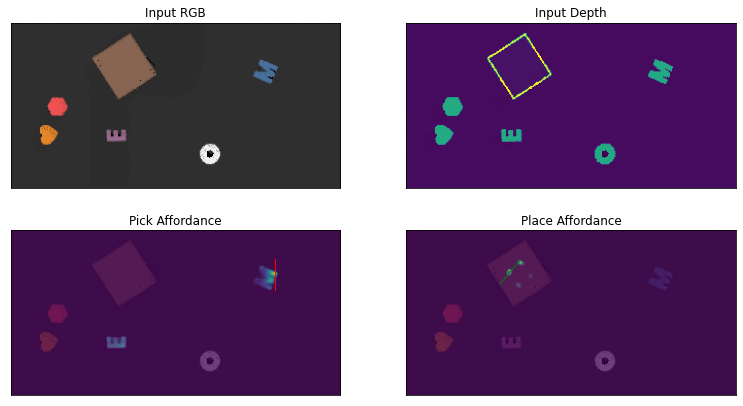

Step: 1 (1 max)
Lang Goal: pack the letter E shape in the brown box


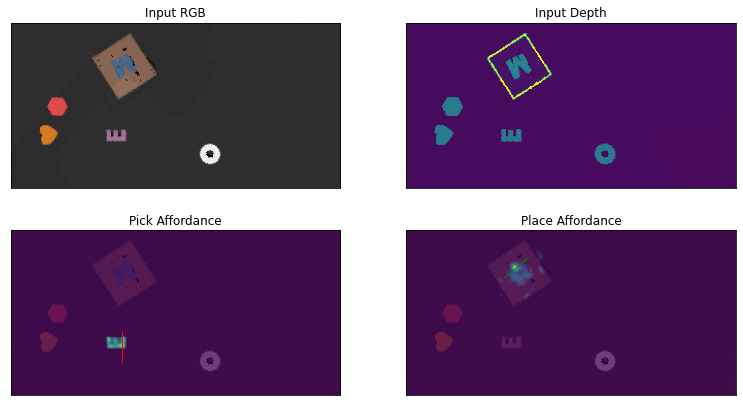

Done. Success.


In [23]:
episode = 0
num_eval_instances = min(n_eval, ds.n_episodes)

for i in range(num_eval_instances):
    print(f'\nEvaluation Instance: {i + 1}/{num_eval_instances}')
    
    # Load episode
    episode, seed = ds.load(i)
    goal = episode[-1]
    total_reward = 0
    np.random.seed(seed)

    # Set task
    task_name = vcfg['eval_task']
    task = tasks.names[task_name]()
    task.mode = mode
    
    # Set environment
    env.seed(seed)
    env.set_task(task)
    obs = env.reset()
    info = env.info
    reward = 0
    
    step = 0
    done = False
    
    # Rollout
    while (step <= task.max_steps) and not done:
        print(f"Step: {step} ({task.max_steps} max)")
        
        # Get batch
        if step == task.max_steps-1:
            batch = ds.process_goal((obs, None, reward, info), perturb_params=None)
        else:
            batch = ds.process_sample((obs, None, reward, info), augment=False)

        fig, axs = plt.subplots(2, 2, figsize=(13, 7))
        
        # Get color and depth inputs
        img = batch['img']
        img = torch.from_numpy(img)
        color = np.uint8(img.detach().cpu().numpy())[:,:,:3]
        color = color.transpose(1,0,2)
        depth = np.array(img.detach().cpu().numpy())[:,:,3]
        depth = depth.transpose(1,0)
        
        # Display input color
        axs[0,0].imshow(color)
        axs[0,0].axes.xaxis.set_visible(False)
        axs[0,0].axes.yaxis.set_visible(False)
        axs[0,0].set_title('Input RGB')
        
        # Display input depth
        axs[0,1].imshow(depth)
        axs[0,1].axes.xaxis.set_visible(False)
        axs[0,1].axes.yaxis.set_visible(False)        
        axs[0,1].set_title('Input Depth')
        
        # Display predicted pick affordance
        axs[1,0].imshow(color)
        axs[1,0].axes.xaxis.set_visible(False)
        axs[1,0].axes.yaxis.set_visible(False)
        axs[1,0].set_title('Pick Affordance')
        
        # Display predicted place affordance
        axs[1,1].imshow(color)
        axs[1,1].axes.xaxis.set_visible(False)
        axs[1,1].axes.yaxis.set_visible(False)
        axs[1,1].set_title('Place Affordance')
        
        # Get action predictions
        l = str(info['lang_goal'])
        act = agent.act(obs, info, goal=None)
        pick, place = act['pick'], act['place']
        
        # Visualize pick affordance
        pick_inp = {'inp_img': batch['img'], 'lang_goal': l}
        pick_conf = agent.attn_forward(pick_inp)
        logits = pick_conf.detach().cpu().numpy()

        pick_conf = pick_conf.detach().cpu().numpy()
        argmax = np.argmax(pick_conf)
        argmax = np.unravel_index(argmax, shape=pick_conf.shape)
        p0 = argmax[:2]
        p0_theta = (argmax[2] * (2 * np.pi / pick_conf.shape[2])) * -1.0
    
        line_len = 30
        pick0 = (pick[0] + line_len/2.0 * np.sin(p0_theta), pick[1] + line_len/2.0 * np.cos(p0_theta))
        pick1 = (pick[0] - line_len/2.0 * np.sin(p0_theta), pick[1] - line_len/2.0 * np.cos(p0_theta))

        if draw_grasp_lines:
            axs[1,0].plot((pick1[0], pick0[0]), (pick1[1], pick0[1]), color='r', linewidth=1)
        
        # Visualize place affordance
        place_inp = {'inp_img': batch['img'], 'p0': pick, 'lang_goal': l}
        place_conf = agent.trans_forward(place_inp)

        place_conf = place_conf.permute(1, 2, 0)
        place_conf = place_conf.detach().cpu().numpy()
        argmax = np.argmax(place_conf)
        argmax = np.unravel_index(argmax, shape=place_conf.shape)
        p1_pix = argmax[:2]
        p1_theta = (argmax[2] * (2 * np.pi / place_conf.shape[2]) + p0_theta) * -1.0
        
        line_len = 30
        place0 = (place[0] + line_len/2.0 * np.sin(p1_theta), place[1] + line_len/2.0 * np.cos(p1_theta))
        place1 = (place[0] - line_len/2.0 * np.sin(p1_theta), place[1] - line_len/2.0 * np.cos(p1_theta))

        if draw_grasp_lines:
            axs[1,1].plot((place1[0], place0[0]), (place1[1], place0[1]), color='g', linewidth=1)
        
        # Overlay affordances on RGB input
        pick_logits_disp = np.uint8(logits * 255 * affordance_heatmap_scale).transpose(1,0,2)
        place_logits_disp = np.uint8(np.sum(place_conf, axis=2)[:,:,None] * 255 * affordance_heatmap_scale).transpose(1,0,2)    

        pick_logits_disp_masked = np.ma.masked_where(pick_logits_disp < 0, pick_logits_disp)
        place_logits_disp_masked = np.ma.masked_where(place_logits_disp < 0, place_logits_disp)

        axs[1][0].imshow(pick_logits_disp_masked, alpha=0.75)
        axs[1][1].imshow(place_logits_disp_masked, cmap='viridis', alpha=0.75)
        
        print(f"Lang Goal: {str(info['lang_goal'])}")
        plt.show()
        
        # Act with the predicted actions
        obs, reward, done, info = env.step(act)
        step += 1
        
    if done:
        print("Done. Success.")
    else:
        print("Max steps reached. Task failed.")


### Sample Model Prediction

In [39]:
episode, seed = ds.load(0)

# Set environment
env.seed(seed)
env.set_task(task)
obs = env.reset()
info = env.info

step = 0
reward = 0

In [40]:
batch = ds.process_sample((obs, None, reward, info), augment=False)

In [41]:
act = agent.act(obs, info, goal=None)
pick, place = act['pick'], act['place']

pybullet build time: Sep 22 2020 00:56:01
text argument:/sfs/weka/scratch/ys5hd/cliport/cliport/environments/assets/
int args: [text argument:/sfs/weka/scratch/ys5hd/cliport/cliport/environments/assets/
int args: [text argument:/sfs/weka/scratch/ys5hd/cliport/cliport/environments/assets/
int args: [

In [46]:
l = str(info['lang_goal'])
pick_inp = {'inp_img': batch['img'], 'lang_goal': l}
pick_conf = agent.attn_forward(pick_inp)
logits = pick_conf.detach().cpu().numpy()

In [53]:
pick_conf = pick_conf.detach().cpu().numpy()
argmax = np.argmax(pick_conf)
argmax = np.unravel_index(argmax, shape=pick_conf.shape)

In [55]:
p0 = argmax[:2]
p0_theta = (argmax[2] * (2 * np.pi / pick_conf.shape[2])) * -1.0

line_len = 30
pick0 = (pick[0] + line_len/2.0 * np.sin(p0_theta), pick[1] + line_len/2.0 * np.cos(p0_theta))
pick1 = (pick[0] - line_len/2.0 * np.sin(p0_theta), pick[1] - line_len/2.0 * np.cos(p0_theta))

In [62]:
place_inp = {'inp_img': batch['img'], 'p0': pick, 'lang_goal': l}
place_conf = agent.trans_forward(place_inp)

In [82]:
place_conf = place_conf.permute(1, 2, 0)
place_conf = place_conf.detach().cpu().numpy()
argmax = np.argmax(place_conf)
argmax = np.unravel_index(argmax, shape=place_conf.shape)

In [84]:
p1_pix = argmax[:2]
p1_theta = (argmax[2] * (2 * np.pi / place_conf.shape[2]) + p0_theta) * -1.0